In [1]:
import os
import sys
import pickle
from tqdm.notebook import tqdm as tqdm
import random

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

sys.path.append("../")

from batch_generators import ContrastiveDataGenerator
from models import ContrastiveRankingModel, metabric_main_network
from tools import test_quality
from clr import cyclic_learning_rate

In [2]:
s = 2

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

##### Load METABRIC data

In [3]:
with open('../data/metabric_cv.pkl', 'rb') as f:
    df_all = pickle.load(f)

In [4]:
df_all.keys()

dict_keys(['val', 'cv'])

In [5]:
df_all['cv'].keys()

dict_keys([0, 1, 2, 3, 4])

In [6]:
folds = list(df_all['cv'].keys())

ContrastiveDataGenerator creates less number of positive examples than BinaryDataGenerator 

that is why we need more epochs to train on

In [160]:
# training data
dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                         n_time_bins=model_params['n_time_bins'])    
n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // model_params['batch_size']
n_batches

83

In [161]:
from batch_generators import BinaryDataGenerator

In [162]:
# training data
dg = BinaryDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                         n_time_bins=model_params['n_time_bins'])    
n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // model_params['batch_size']
n_batches

495

In [163]:
495/83

5.963855421686747

In [164]:
30*6

180

### Learning rate range test

In [7]:
def ContrastiveModel_opt(train_data, test_data, fold, model_params):
    
    model = ContrastiveRankingModel(input_shape=model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'], 
                               main_network=metabric_main_network, contrastive_weight=model_params['contrastive_weight'])
    
    all_lr = []
    step_rate = 1
    decay = 1.1
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = tf.train.exponential_decay(model_params['learning_rate'], global_step, step_rate, decay, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    
    train = optimizer.minimize(model.loss)
    
    # validation data
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], 
                                  n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())
    val_size = x_batch_left_val.shape[0]
    # training data
    dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // model_params['batch_size']

    all_pred = []
    train_loss = []
    val_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(s)
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in range(model_params['n_epochs']):
                # initialize generator
                gen = dg.get_batch()
                # for each batch
                for j in range(n_batches):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }                   
                    # train model
                    _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                    train_loss.append(l)
                new_lr = sess.run(optimizer._learning_rate_tensor)
                print("lr: ", new_lr)
                all_lr.append(new_lr)
                sess.run(increment_global_step)
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save test loss
                l = sess.run(model.loss, feed_dict={
                        model.x_a: x_batch_left_val, 
                        model.x_b: x_batch_right_val, 
                        model.t_a: y_batch_val[:, 0].reshape((val_size, 1)),
                        model.t_b: y_batch_val[:, 1].reshape((val_size, 1)),
                        model.y_a: y_batch_val[:, 2].reshape((val_size, 1)),
                        model.y_b: y_batch_val[:, 3].reshape((val_size, 1)),
                        model.target: target_val.reshape((val_size, 1)),
                        model.sample_weight: sample_weight_val
                    }) 
                val_loss.append(l)
                
    return pred, train_loss, val_loss, all_lr


In [99]:
model_params = {
    'n_time_bins': 10, 
    'time_grid': np.linspace(0, 300, 30, dtype=np.int),
    'inp_shape': (None, 9),
    'n_epochs': 60,
    'batch_size': 1024,
    'learning_rate': 0.0001,
    'alpha_reg': 0.001,
    'model_path': '../model/test_',
    'contrastive_weight': 1,
    'seed': s
}

folds = np.arange(0, 5, 1)

In [100]:
fold = 0

In [101]:
all_res_quality = []
train_data = df_all['cv'][fold]['train']
test_data = df_all['cv'][fold]['test']
tf.reset_default_graph()
pred, train_loss, val_loss, all_lr = ContrastiveModel_opt(train_data=train_data, test_data=test_data, fold=fold, model_params=model_params)
q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=model_params['time_grid'], concordance_at_t=103)
q['fold'] = fold
q['train_loss'] = [train_loss]
q['val_loss'] = [val_loss]
all_res_quality.append(q)

lr:  1e-04
lr:  0.00011
lr:  0.000121
lr:  0.00013310001
lr:  0.00014641
lr:  0.00016105102
lr:  0.00017715611
lr:  0.00019487174
lr:  0.00021435892
lr:  0.00023579483
lr:  0.0002593743
lr:  0.00028531175
lr:  0.0003138429
lr:  0.00034522722
lr:  0.00037974995
lr:  0.00041772498
lr:  0.00045949747
lr:  0.0005054472
lr:  0.0005559919
lr:  0.00061159115
lr:  0.0006727503
lr:  0.0007400253
lr:  0.0008140278
lr:  0.0008954306
lr:  0.0009849737
lr:  0.0010834712
lr:  0.0011918183
lr:  0.0013110001
lr:  0.0014421003
lr:  0.0015863101
lr:  0.0017449415
lr:  0.0019194355
lr:  0.002111379
lr:  0.002322517
lr:  0.002554769
lr:  0.002810246
lr:  0.0030912703
lr:  0.0034003977
lr:  0.0037404373
lr:  0.004114481
lr:  0.004525929
lr:  0.004978522
lr:  0.0054763746
lr:  0.006024013
lr:  0.0066264127
lr:  0.007289055
lr:  0.008017961
lr:  0.008819757
lr:  0.0097017335
lr:  0.010671906
lr:  0.0117390985
lr:  0.012913008
lr:  0.014204308
lr:  0.01562474
lr:  0.017187215
lr:  0.018905936
lr:  0.020796532

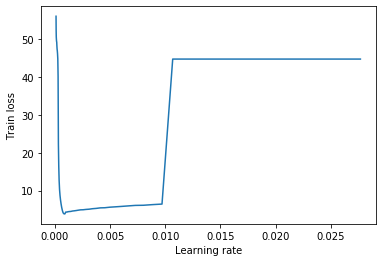

In [113]:
row = q['train_loss'].values[0]
plt.plot(all_lr, val_loss, label='train')
plt.xlabel('Learning rate')
plt.ylabel('Train loss')
plt.show()

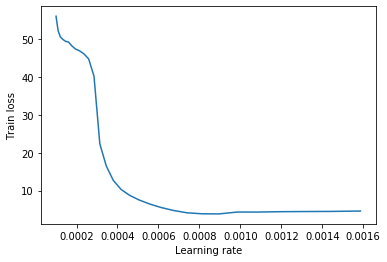

In [115]:
row = q['train_loss'].values[0]
plt.plot(all_lr[:30], val_loss[:30], label='train')
plt.xlabel('Learning rate')
plt.ylabel('Train loss')
plt.show()

near optimal learning rate = 0.0001

tried cycling learning rate but it gave unstable results

In [61]:
# def test_hp(train_data, test_data, model_params):
    
#     model = ContrastiveRankingModel(input_shape=model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'], 
#                                main_network=metabric_main_network, contrastive_weight=model_params['contrastive_weight'])

#     # cycling learning rate
#     all_lr = []
#     global_step = tf.Variable(0, trainable=False)
#     increment_global_step = tf.assign(global_step, global_step + 1)
#     learning_rate = cyclic_learning_rate(global_step=global_step, learning_rate=model_params['max_lr'] / 5, max_lr=model_params['max_lr'], 
#                                          step_size=model_params['step_size'], mode='triangular2')
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#     train = optimizer.minimize(model.loss, global_step=global_step)
    
#     # constant learning rate
# #     optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
# #     train = optimizer.minimize(model.loss)
    
#     # validation data
#     dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], 
#                                   n_time_bins=model_params['n_time_bins'])
#     val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
#     dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
#     [x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())
#     val_size = x_batch_left_val.shape[0]
#     # training data
#     dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
#                              n_time_bins=model_params['n_time_bins'])    
#     n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // model_params['batch_size']
#     n_epochs = model_params['n_epochs']
    
#     all_lr = []
#     all_pred = []
#     train_loss = []
#     val_loss = []
#     # Launch the graph
#     with tf.device('/GPU:0'):
#         with tf.Session() as sess:
#             tf.set_random_seed(model_params['seed'])
#             init = tf.initialize_all_variables()
#             sess.run(init)
#             # for each epoch
#             for i in tqdm(range(n_epochs)):
#                 # initialize generator
#                 gen = dg.get_batch()
#                 # for each batch
#                 for j in range(n_batches):
#                     # get batch data
#                     [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
#                     feed_dict = {
#                         model.x_a: x_batch_left, 
#                         model.x_b: x_batch_right, 
#                         model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
#                         model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
#                         model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
#                         model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
#                         model.target: target.reshape((model_params['batch_size'], 1)),
#                         model.sample_weight: sample_weight
#                     }
                    
#                     # train model
#                     _, l = sess.run([train, model.loss], feed_dict=feed_dict)

#                  # change learning rate
#                 assign_op = global_step.assign(i)
#                 sess.run(assign_op)               
#                 new_lr = sess.run(optimizer._learning_rate_tensor)
#                 all_lr.append(new_lr)
              
#                 # get predictions for validation data
#                 pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
#                 all_pred.append(pred)
#                 # save train loss
#                 train_loss.append(l)
#                 # save test loss
#                 l = sess.run([model.loss], feed_dict={
#                     model.x_a: x_batch_left_val, 
#                     model.x_b: x_batch_right_val, 
#                     model.t_a: y_batch_val[:, 0].reshape((val_size, 1)),
#                     model.t_b: y_batch_val[:, 1].reshape((val_size, 1)),
#                     model.y_a: y_batch_val[:, 2].reshape((val_size, 1)),
#                     model.y_b: y_batch_val[:, 3].reshape((val_size, 1)),
#                     model.target: target_val.reshape((val_size, 1)),
#                     model.sample_weight: sample_weight_val
#                 }) 
#                 val_loss.append(l)

#     return pred, train_loss, val_loss, all_lr
# #     return pred, train_loss, val_loss

Grid search

In [7]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs = 180

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs': n_epochs,
    'seed': s,
    'time_grid': time_grid   
}

In [56]:
# 72 combinations
batch_size = [1024, 2048]
alpha_reg = [1e-4, 1e-5, 1e-6]
contrastive_weight = [2, 1, 1e-1, 1e-3]
learning_rate = [0.0001, 0.0002, 0.0003]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
    'learning_rate': learning_rate,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [ ]:
all_res_quality = []
test_data = df_all['val']
for fold in tqdm(folds):
    train_data = df_all['cv'][fold]['train']
    for params in tqdm(grid):
        tf.reset_default_graph()
        params.update(static_params)
        pred, train_loss, val_loss = test_hp(train_data=train_data, test_data=test_data, model_params=params)
        q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103)
        q['batch_size'] = params['batch_size']
        q['alpha_reg'] = params['alpha_reg']
        q['contrastive_weight'] = params['contrastive_weight']
        q['fold'] = fold
        q['train_loss'] = [train_loss]
        q['val_loss'] = [val_loss]
        q['learning_rate'] = params['learning_rate']
        all_res_quality.append(q)
        
        with open('../output/hp_search_w_contr_v1.pkl', 'wb') as f:
            pickle.dump(all_res_quality, f)





Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Analyze results

In [43]:
with open('../output/hp_search_w_contr_v1.pkl', 'rb') as f:
    data = pickle.load(f)

In [44]:
data = pd.concat(data)

In [45]:
data.sort_values('dt_c_index', ascending=False)

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,contrastive_weight,fold,train_loss,val_loss,learning_rate
0,0.658762,0.654783,0.172530,0.505871,1024,0.00001,0.100,0,"[44.634457, 36.580055, 11.877091, 9.302651, 7....","[[43.349392], [36.460922], [12.835134], [9.427...",0.0003
0,0.658882,0.654543,0.173775,0.508957,1024,0.00010,0.100,0,"[44.901398, 37.93141, 12.37571, 9.4865885, 7.9...","[[43.32497], [38.088314], [13.330557], [9.6192...",0.0003
0,0.655183,0.653823,0.176908,0.516819,1024,0.00001,1.000,0,"[48.145058, 46.07523, 44.742043, 46.54199, 45....","[[45.929337], [45.51803], [45.356644], [45.240...",0.0003
0,0.654783,0.653043,0.178163,0.520059,1024,0.00010,1.000,0,"[48.14542, 46.07562, 44.742306, 46.542263, 45....","[[45.92958], [45.518272], [45.35685], [45.2405...",0.0003
0,0.653163,0.652623,0.173275,0.508352,1024,0.00001,0.100,0,"[44.924725, 40.294353, 28.980566, 12.923319, 9...","[[43.442238], [40.244408], [29.391626], [13.47...",0.0002
0,0.658202,0.652343,0.175013,0.511658,1024,0.00001,0.001,0,"[38.885937, 18.804981, 10.053289, 8.693216, 7....","[[38.503242], [18.188457], [9.055749], [7.1504...",0.0003
0,0.653723,0.652083,0.174539,0.511416,1024,0.00010,0.100,0,"[44.925377, 40.295254, 28.983427, 12.929912, 9...","[[43.443085], [40.245155], [29.39398], [13.482...",0.0002
0,0.658182,0.651884,0.176246,0.514762,1024,0.00010,0.001,0,"[39.4466, 19.19183, 10.299641, 8.975388, 6.751...","[[38.74154], [18.173952], [9.042938], [7.08539...",0.0003
0,0.652343,0.651024,0.174285,0.511643,2048,0.00010,0.100,0,"[44.67519, 43.604656, 41.31154, 36.308037, 19....","[[44.35045], [43.341343], [41.622128], [35.243...",0.0003
0,0.647825,0.650524,0.177121,0.517902,1024,0.00001,1.000,0,"[48.77369, 46.269184, 44.894306, 46.77148, 45....","[[46.61667], [45.902885], [45.63979], [45.4645...",0.0002


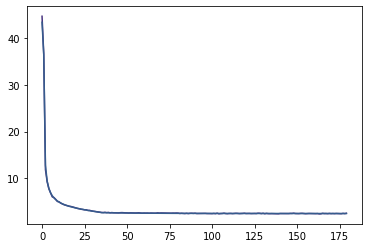

In [29]:
plt.plot(data.sort_values('dt_c_index', ascending=False).iloc[0]['train_loss'])
plt.plot(data.sort_values('dt_c_index', ascending=False).iloc[0]['val_loss'])

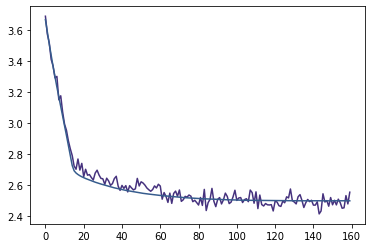

In [30]:
plt.plot(data.sort_values('dt_c_index', ascending=False).iloc[0]['train_loss'][20:])
plt.plot(data.sort_values('dt_c_index', ascending=False).iloc[0]['val_loss'][20:])

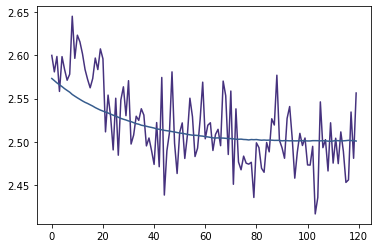

In [35]:
plt.plot(data.sort_values('dt_c_index', ascending=False).iloc[0]['train_loss'][90:])
plt.plot(data.sort_values('dt_c_index', ascending=False).iloc[0]['val_loss'][90:])

На основании данных фолда 0 в целом результаты хуже, чем для Weibull Model. Лучшими параметрами являются те же, что и для Weibull Model, но max concordance_dt - 0.654783, в то время как для Weibull Mode - 0.659

На этом генераторе 180 эпох занимают столько же времени для обучения, сколько 30 эпох для BinaryBatchGenerator

Try another optimizer - MomentumOptimizer

In [7]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs = 180

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs': n_epochs,
    'seed': s,
    'time_grid': time_grid   
}

In [17]:
batch_size = [1024]
alpha_reg = [1e-6]
contrastive_weight = [5e-1]
learning_rate = [0.0003]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
    'learning_rate': learning_rate,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [18]:
def test_hp(train_data, test_data, model_params):
    
    model = ContrastiveRankingModel(input_shape=model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'], 
                               main_network=metabric_main_network, contrastive_weight=model_params['contrastive_weight'])

    # validation data
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], 
                                  n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())
    val_size = x_batch_left_val.shape[0]
    # training data
    dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // model_params['batch_size']
    n_epochs = model_params['n_epochs']
    
    # decaying learning rate
    NUM_EPOCHS_PER_DECAY = 90
    LEARNING_RATE_DECAY_FACTOR = 0.5
    MOMENTUM_DECAY_FACTOR = 0.7
    decay_steps=int(n_batches * NUM_EPOCHS_PER_DECAY)
    global_step=tf.Variable(0,trainable=False)
    decayed_learning_rate = tf.train.exponential_decay(0.0003, 
                                                         global_step, 
                                                         decay_steps, 
                                                         LEARNING_RATE_DECAY_FACTOR,
                                                         staircase=True)
    decayed_momentum = tf.train.exponential_decay(0.8, 
                                                         global_step, 
                                                         decay_steps, 
                                                         MOMENTUM_DECAY_FACTOR,
                                                         staircase=True)
    optimizer = tf.train.MomentumOptimizer(learning_rate=decayed_learning_rate, momentum=decayed_momentum)
    train = optimizer.minimize(model.loss, global_step=global_step)
    
    all_lr = []
    all_pred = []
    train_loss = []
    val_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(n_epochs)):
                # initialize generator
                gen = dg.get_batch()
                # for each batch
                for j in range(n_batches):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l = sess.run([train, model.loss], feed_dict=feed_dict)
              
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                # save test loss
                l = sess.run([model.loss], feed_dict={
                    model.x_a: x_batch_left_val, 
                    model.x_b: x_batch_right_val, 
                    model.t_a: y_batch_val[:, 0].reshape((val_size, 1)),
                    model.t_b: y_batch_val[:, 1].reshape((val_size, 1)),
                    model.y_a: y_batch_val[:, 2].reshape((val_size, 1)),
                    model.y_b: y_batch_val[:, 3].reshape((val_size, 1)),
                    model.target: target_val.reshape((val_size, 1)),
                    model.sample_weight: sample_weight_val
                }) 
                val_loss.append(l)

#     return pred, train_loss, val_loss, all_lr
    return pred, train_loss, val_loss

In [19]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
params = grid[0]
tf.reset_default_graph()
params.update(static_params)
pred, train_loss, val_loss = test_hp(train_data=train_data, test_data=test_data, model_params=params)
q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103)
q['batch_size'] = params['batch_size']
q['alpha_reg'] = params['alpha_reg']
q['fold'] = fold
q['train_loss'] = [train_loss]
q['val_loss'] = [val_loss]
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.644285,0.62679,0.179088,0.52852,1024,0.000001,0,"[37.20159, 21.234667, 12.433232, 9.608148, 4.5...","[[36.186386], [19.85185], [12.409223], [9.5420..."


Cмотреть результаты снизу вверх - сначала оптимизировали MomentumOptimizer, потом попробовали изменить коэффициент для sample weight (величину margin) и стало хуже качество, поэтому интересно посмотреть, какая есть зависимость от этого параметра и от contrastive weight

In [ ]:
# sample weight * 0.8 + contrastive weight 0.5

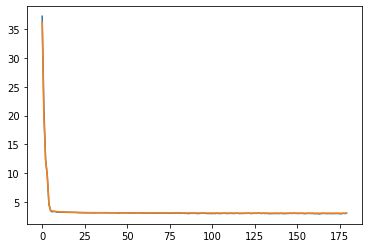

In [21]:
plt.plot(train_loss)
plt.plot(val_loss)

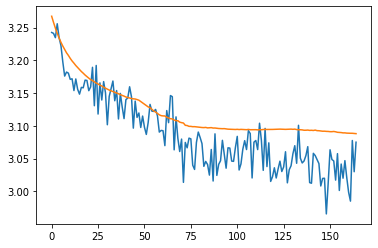

In [22]:
plt.plot(train_loss[15:])
plt.plot(val_loss[15:])

In [20]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.644285,0.62679,0.179088,0.52852,1024,0.000001,0,"[37.20159, 21.234667, 12.433232, 9.608148, 4.5...","[[36.186386], [19.85185], [12.409223], [9.5420..."


In [ ]:
# sample weight * 0.8

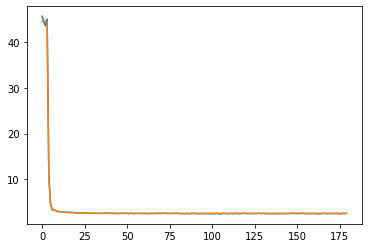

In [12]:
plt.plot(train_loss)
plt.plot(val_loss)

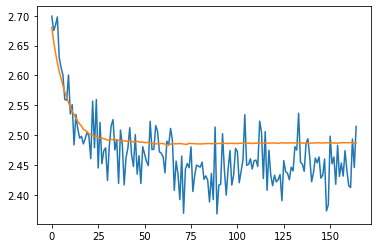

In [13]:
plt.plot(train_loss[15:])
plt.plot(val_loss[15:])

In [14]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.657662,0.656322,0.172993,0.506795,1024,0.000001,0,"[45.74909, 44.714973, 43.632904, 45.11147, 10....","[[44.642735], [44.642735], [44.642735], [44.36..."


In [ ]:
#### best MomentumOptimizer + less sample weight 

In [ ]:
# best - MomentumOptimizer 0.8 + momentum decay 0.7 180 эпох decay_step 90 LEARNING_RATE_DECAY_FACTOR 0.5

In [65]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.657642,0.656662,0.17272,0.505968,1024,0.000001,0,"[45.763042, 44.729153, 43.64672, 45.13337, 10....","[[44.656635], [44.656635], [44.656635], [44.38..."


In [80]:
# MomentumOptimizer 0.8 + momentum decay 0.7 60 эпох + decay_step 45 + LEARNING_RATE_DECAY_FACTOR = 0.5 -> 0.8

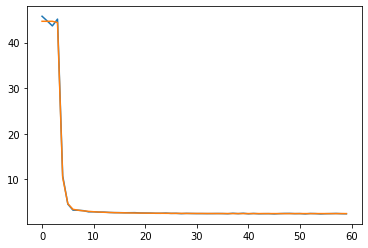

In [83]:
plt.plot(train_loss)
plt.plot(val_loss)

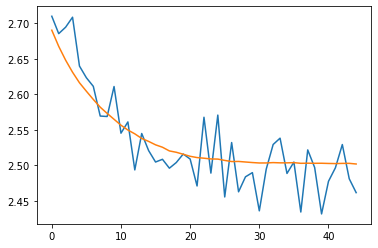

In [84]:
plt.plot(train_loss[15:])
plt.plot(val_loss[15:])

In [85]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.658582,0.654263,0.173125,0.50713,1024,0.000001,0,"[45.763042, 44.729153, 43.64672, 45.13337, 10....","[[44.656635], [44.656635], [44.656635], [44.38..."


In [ ]:
# MomentumOptimizer 0.8 + momentum decay 0.6 60 эпох + decay_step = 90 -> 45

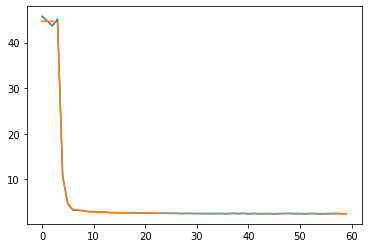

In [77]:
plt.plot(train_loss)
plt.plot(val_loss)

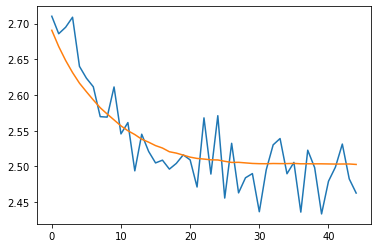

In [78]:
plt.plot(train_loss[15:])
plt.plot(val_loss[15:])

In [79]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.657662,0.654083,0.173085,0.507083,1024,0.000001,0,"[45.763042, 44.729153, 43.64672, 45.13337, 10....","[[44.656635], [44.656635], [44.656635], [44.38..."


In [ ]:
# MomentumOptimizer 0.8 + momentum decay 0.7 60 эпох

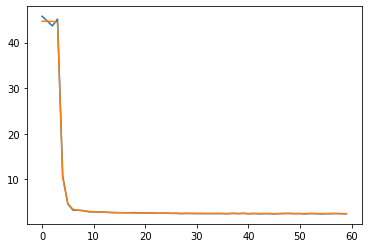

In [72]:
plt.plot(train_loss)
plt.plot(val_loss)

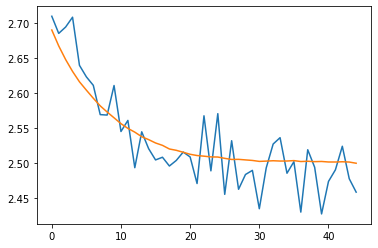

In [73]:
plt.plot(train_loss[15:])
plt.plot(val_loss[15:])

In [74]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.659802,0.655743,0.172812,0.506175,1024,0.000001,0,"[45.763042, 44.729153, 43.64672, 45.13337, 10....","[[44.656635], [44.656635], [44.656635], [44.38..."


In [ ]:
# MomentumOptimizer 0.8 + momentum decay 0.7 все 180 эпох

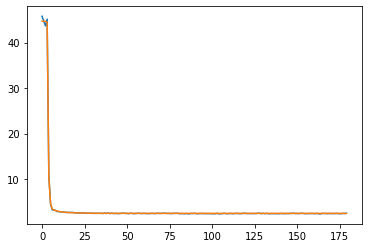

In [63]:
plt.plot(train_loss)
plt.plot(val_loss)

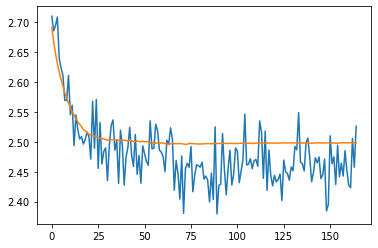

In [64]:
plt.plot(train_loss[15:])
plt.plot(val_loss[15:])

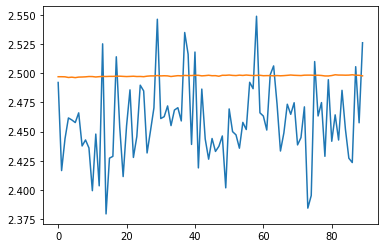

In [66]:
plt.plot(train_loss[90:])
plt.plot(val_loss[90:])

In [65]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.657642,0.656662,0.17272,0.505968,1024,0.000001,0,"[45.763042, 44.729153, 43.64672, 45.13337, 10....","[[44.656635], [44.656635], [44.656635], [44.38..."


In [ ]:
# MomentumOptimizer 0.7 + momentum decay 0.7

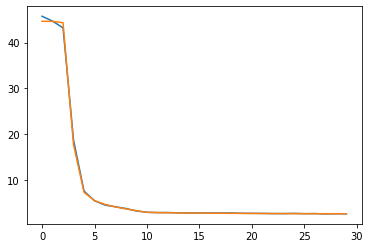

In [52]:
plt.plot(train_loss)
plt.plot(val_loss)

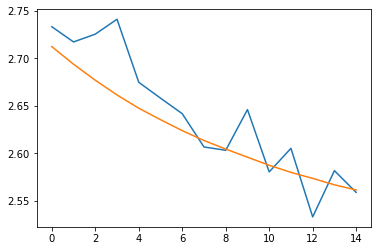

In [53]:
plt.plot(train_loss[15:])
plt.plot(val_loss[15:])

In [54]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.630609,0.639387,0.180524,0.527389,1024,0.000001,0,"[45.759895, 44.695614, 43.222263, 18.686705, 7...","[[44.656635], [44.637844], [44.351433], [17.68..."


In [ ]:
# MomentumOptimizer 0.8 + momentum decay 0.7

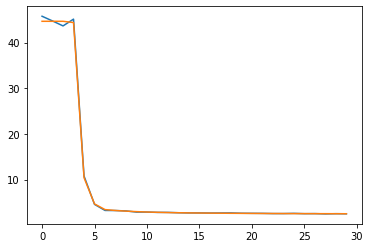

In [47]:
plt.plot(train_loss)
plt.plot(val_loss)

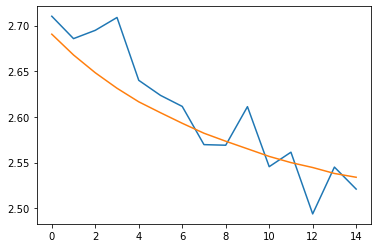

In [48]:
plt.plot(train_loss[15:])
plt.plot(val_loss[15:])

In [49]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.639087,0.644205,0.177205,0.518257,1024,0.000001,0,"[45.763042, 44.729153, 43.64672, 45.13337, 10....","[[44.656635], [44.656635], [44.656635], [44.38..."


In [ ]:
# MomentumOptimizer 0.9 + momentum decay 0.7

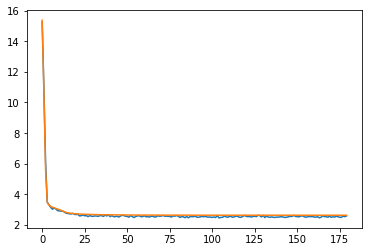

In [34]:
plt.plot(train_loss)
plt.plot(val_loss)

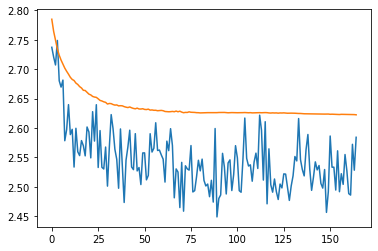

In [39]:
plt.plot(train_loss[15:])
plt.plot(val_loss[15:])

In [36]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.655243,0.636867,0.17077,0.504832,1024,0.000001,0,"[15.261533, 10.991351, 6.110474, 3.4734888, 3....","[[15.372765], [10.7310915], [5.595761], [3.472..."


In [ ]:
# MomentumOptimizer 0.9

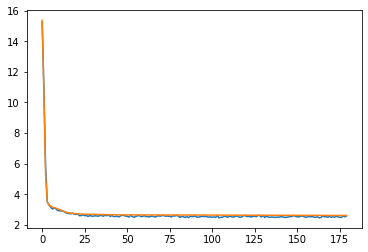

In [28]:
plt.plot(train_loss)
plt.plot(val_loss)

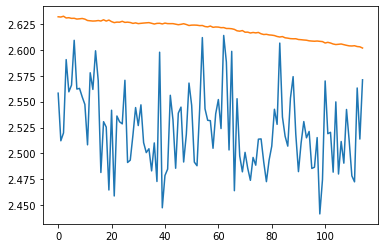

In [30]:
plt.plot(train_loss[65:])
plt.plot(val_loss[65:])

In [32]:
q

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,fold,train_loss,val_loss
0,0.658162,0.642626,0.17028,0.502885,1024,0.000001,0,"[15.261533, 10.999992, 5.865133, 3.4932232, 3....","[[15.372765], [10.670365], [5.2846556], [3.493..."


Посмотрим на влияние гиперапараметров на качество

In [1]:
import os
import sys
import pickle
from tqdm.notebook import tqdm as tqdm
import random

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

sys.path.append("../")

from batch_generators import ContrastiveDataGenerator
from models import ContrastiveRankingModel, metabric_main_network
from tools import test_quality
from clr import cyclic_learning_rate

In [2]:
s = 2

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

##### Load METABRIC data

In [3]:
with open('../data/metabric_cv.pkl', 'rb') as f:
    df_all = pickle.load(f)

In [4]:
df_all.keys()

dict_keys(['val', 'cv'])

In [5]:
df_all['cv'].keys()

dict_keys([0, 1, 2, 3, 4])

In [6]:
folds = list(df_all['cv'].keys())

In [7]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs = 180

learning_rate = 0.0003
learning_rate_decay_factor = 0.5
momentum = 0.8
momentum_decay_factor = 0.7
num_epochs_per_decay = 90

batch_size = 1024
alpha_reg = 1e-6

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs': n_epochs,
    'seed': s,
    'time_grid': time_grid,
    'learning_rate': learning_rate,
    'learning_rate_decay_factor': learning_rate_decay_factor,
    'momentum': momentum,
    'momentum_decay_factor': momentum_decay_factor,
    'num_epochs_per_decay': num_epochs_per_decay,
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
}

In [20]:
param_grid = {
    'contrastive_weight': np.logspace(-3, 0, 4),
    'margin_weight': np.logspace(-3, 1, 5)
}
grid = ParameterGrid(param_grid)

In [21]:
len(grid)

20

In [22]:
def test_hp(train_data, test_data, model_params):
    
    model = ContrastiveRankingModel(input_shape=model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'], 
                                    main_network=metabric_main_network, 
                                    contrastive_weight=model_params['contrastive_weight'], margin_weight=model_params['margin_weight'])

    # validation data
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], 
                                  n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())
    val_size = x_batch_left_val.shape[0]
    # training data
    dg = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // model_params['batch_size']
    n_epochs = model_params['n_epochs']
    
    # decaying learning rate and momentum optimizer
    decay_steps = int(n_batches * model_params['num_epochs_per_decay'])
    global_step = tf.Variable(0, trainable=False)
    decayed_learning_rate = tf.train.exponential_decay(model_params['learning_rate'], 
                                                         global_step, 
                                                         decay_steps, 
                                                         model_params['learning_rate_decay_factor'],
                                                         staircase=True)
    decayed_momentum = tf.train.exponential_decay(model_params['momentum'], 
                                                         global_step, 
                                                         decay_steps, 
                                                         model_params['momentum_decay_factor'],
                                                         staircase=True)
    optimizer = tf.train.MomentumOptimizer(learning_rate=decayed_learning_rate, momentum=decayed_momentum)
    train = optimizer.minimize(model.loss, global_step=global_step)
    
    all_lr = []
    all_pred = []
    train_loss = []
    val_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(model_params['n_epochs'])):
                # initialize generator
                gen = dg.get_batch()
                # for each batch
                for j in range(n_batches):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l = sess.run([train, model.loss], feed_dict=feed_dict)
              
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                # save test loss
                l = sess.run([model.loss], feed_dict={
                    model.x_a: x_batch_left_val, 
                    model.x_b: x_batch_right_val, 
                    model.t_a: y_batch_val[:, 0].reshape((val_size, 1)),
                    model.t_b: y_batch_val[:, 1].reshape((val_size, 1)),
                    model.y_a: y_batch_val[:, 2].reshape((val_size, 1)),
                    model.y_b: y_batch_val[:, 3].reshape((val_size, 1)),
                    model.target: target_val.reshape((val_size, 1)),
                    model.sample_weight: sample_weight_val
                }) 
                val_loss.append(l)

    return pred, train_loss, val_loss

In [23]:
folds = [1, 2, 3, 4]

In [24]:
all_res_quality = []
test_data = df_all['val']
for fold in tqdm(folds):
    train_data = df_all['cv'][fold]['train']
    for params in tqdm(grid):
        tf.reset_default_graph()
        params.update(static_params)
        pred, train_loss, val_loss = test_hp(train_data=train_data, test_data=test_data, model_params=params)
        q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103)
        q['batch_size'] = params['batch_size']
        q['alpha_reg'] = params['alpha_reg']
        q['contrastive_weight'] = params['contrastive_weight']
        q['margin_weight'] = params['margin_weight']
        q['fold'] = fold
        q['train_loss'] = [train_loss]
        q['val_loss'] = [val_loss]
        all_res_quality.append(q)
        
        with open('../output/hp_search_w_contr_v2.pkl', 'wb') as f:
            pickle.dump(all_res_quality, f)

Analyze results

20-30 эпох учим main_loss используя BinaryDataGenerator, а потом 30 эпох доучиваем полный лосс используя Contrastive DataGenerator (первые 5 - с заморозкой всего кроме o1_transformed весов, остальные эпохи - все вместе). При этом проходимся грид сёчем по contrastive_weight и margin_weight